# Experiments with textual misinformation detection using machine learning models
In this experiment, we train and test machine learning models for detecting misinformation based purely on the text. We evaluated the performance of 5 classification models with wide use in text classification problems.

**Models:**
* Logistic regression
* Bernoulli Naive-Bayes
* Multinomial Naive-Bayes
* Linear SVM
* KNN
* Random forest
* Gradient Boosting
* Multilayer Perceptron

# NOTES TO MYSELF

**To do:**
* dimensionality reduction: pca, t-sne
* hyperparamater tunning; validation

**References:**
* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training


In [1]:
#utils
import emoji, re, string, time
from utils import getTestMetrics
import pandas as pd
import numpy as np
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

start_time = time.time()

## Experiments
1. **ml-bow**<br> 
One of the best so far. Best F1: 0.6429 random forest<br>

* **ml-tfidf** <br>
Comparable with ml-bow. Best F1: 0.6278 random forest<br>

* **ml-tfidf-processed**<br>
Comparable with ml-bow and ml-tfidf. The pre-processing didn't had great impact. Precision slightly better.
Best F1: 0.6184 random forest<br>

* **ml-bow-processed**<br>
Same as ml-tfidf-processed. Best F1: 0.6254 random forest  <br>

* **ml-tfidf-smote**<br>
Good result. Smote improves F1 when using tf-idf. Best F1: 0.6426 random forest<br>

* **ml-tfidf-undersampling** <br>
Very poor approach. Undersampling is a bad ideia. Increases recall but greatly reduces accuracy. Best F1: 0.3570 bernoulli naive-bayes<br>

* **ml-tfidf-processed-smote**<br>
Good result. Best F1: 0.6470 random forest <br>

* **ml-bow-processed-smote**<br>
Poor. Smote does not goes well with bow. Best F1: 0.4037 bernoulli naive-bayes<br>

* **ml-bow-random_oversampling**<br>
Holy shit!!! This approuch overcame all the expectations! Best F1: 0.9658 random forest

* **ml-tfidf-random_oversampling**<br>
Very similar with ml-bow-random_oversampling.

* **ml-bow-random_oversampling-processed**<br>




### Conclusions:
* Smote is not the best oversampling technique for text, specially for BOW features
* Pre-processing the data didn't appear to have a great impact, despite the great reduction of dimentionality
* BOW features are comparably to TF-IDF features
* Random oversampling is a great oversampling technique!

| experiment                           | best f1                       | best recall                    | best precision               |
|--------------------------------------|-------------------------------|--------------------------------|------------------------------|
| ml-bow                               | 0.6429 random forest          | 0.6026 mlp                     | 0.8892 random forest         |
| ml-tfidf                             | 0.6278 random forest          | 0.569 mlp                      | 0.9287 random forest         |
| ml-tfidf-processed                   | 0.6184 random forest          | 0.5227 mlp                     | 0.9345 random forest         |
| ml-bow-processed                     | 0.6254 random forest          | 0.5581 mlp                     | 0.8962 random forest         |
| ml-tfidf-smote                       | 0.6426 random forest          | 0.8159 multinomial naive-bayes | 0.8095 random forest         |
| ml-tfidf-undersampling               | 0.3570 bernoulli naive-bayes  | 0.9949 multinomial naive-bayes | 0.2858 bernoulli naive bayes |
| ml-tfidf-processed-smote             | 0.6470 random forest          | 0.7997 multinomial naive-bayes | 0.8211 random forest         |
| ml-bow-processed-smote               |  0.4037 bernoulli naive-bayes | 0.6693 knn                     | 0.3288 bernoulli naive-bayes |
| ml-bow-random_oversampling           | 0.9647 random forest          | 0.9630 logistic regression     | 0.9742 random forest         |
| ml-tfidf-random_oversampling         | 0.9640 random forest          | 0.9659 svm                     | 0.9794 random forest         |
| ml-bow-random_oversampling-processed | 0.9552 random forest          | 0.9519 logistic regression     | 0.9687 random forest         |

In [2]:
#df.style.background_gradient(cmap='Blues')

In [3]:
base = 2018
pre_processed = False
experiment = 'ml-tfidf-random_oversampling-processed' #'ml-tfidf-random_oversampling-processed'
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv(filepath)
df.head(5)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
2,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
3,-4391661641377612003,01/08/18,13:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,5,1,0,1,Boaaa,0
4,-4391661641377612003,09/08/18,14:46,55,BRASIL,BRA,13,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0


# Corpus statistics

In [4]:
df.describe()[['characters','words','sharings']]

,characters,words,sharings
count,282601.000000,282601.000000,282601.000000
mean,97.638688,14.962091,1.755716
std,407.238452,61.842076,5.122241
min,1.000000,1.000000,1.000000
25%,25.000000,4.000000,1.000000
50%,25.000000,4.000000,1.000000
75%,43.000000,7.000000,1.000000
max,65536.000000,5486.000000,91.000000


In [5]:
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

total data


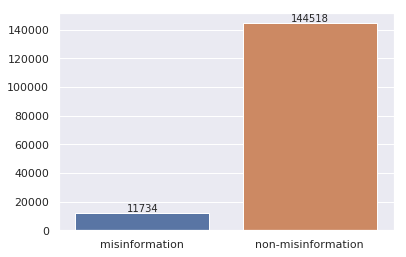

In [6]:
print('total data')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

data after remove duplicates


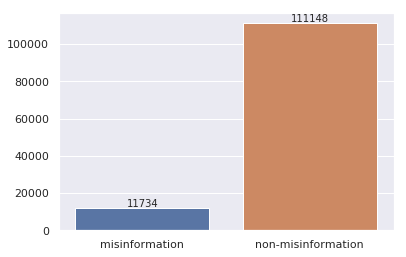

In [7]:
#removing duplicates
if 'random_oversampling' in experiment:
    df_neg = df[df['misinformation']==0].drop_duplicates(subset=['text'])
    df_pos = df[df['misinformation']==1]
    df = pd.concat([df_neg,df_pos])
    df = df.sample(frac=1).reset_index(drop=True) 

else:
    df = df.drop_duplicates(subset=['text'])
    
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [8]:
print(len(texts))
print(len(y))

122882
122882


# Pre-processing
* convert url in just the domain
* separate emojis
* punctuation

[Some suggestions in this work](https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb)

* **Special character cleaning**

* **Upcase/downcase**

* **Punctuation signs** 

* **Possessive pronouns**

* **Stemming or Lemmatization**

* **Stop words**

In [9]:
#emojis and punctuation
emojis_list = list(emoji.UNICODE_EMOJI.keys())
punct = list(string.punctuation)
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = True):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:
        #remove punctuation
        if remove_punct:
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')
            if c in punct:
                text = text.replace(c, ' ')
                
        #put spaces between punctuation
        else:
            if c in emojis_punct:
                text = text.replace(c, ' ' + c + ' ')          
            
    text = text.replace('  ', ' ')
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','kkk','kkkk','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = text.replace('  ',' ')
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text
    

def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''    
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text 

def preprocess(text):
    text = text.lower().strip()
    text = domainUrl(text)
    text = processEmojisPunctuation(text)
    text = removeStopwords(text)
    text = lemmatization(text)
    return text
           

In [10]:
#if experiment is with pre-processed text
if 'processed' in experiment:
        #text was already pre-processed
        if pre_processed:
            pro_texts = pickle.load(open( "data/2018/processed_texts_random-oversampling.p", "rb" ))            
        else:
            pro_texts = [preprocess(t) for t in texts]
            pickle.dump(pro_texts, open( "data/2018/processed_texts_random-oversampling.p", "wb" ))
else:
    pro_texts = [t for t in texts]

In [11]:
list(zip(pro_texts[0:10], texts[0:10]))

[('amar todo grupar pessoal 😭 😭 😭 😭 ', 'Amo todos aqui do grupo pessoal 😭😭😭😭'),
 (' 👍 🏼 👍 🏼 👍 🏼 👍 🏼 1⃣7⃣ ☑ ', '👍🏼👍🏼👍🏼👍🏼1⃣7⃣☑'),
 ('galera ', 'Galera !'),
 ('bomba \ncid gomar irmão ciro gomar atacar violentamente pt \nmal palancar haddad  \nser bolsonaro nele \n 🇧 🇷 😎 🇧 🇷 😎 🇧 🇷 😎 🇧 🇷 ',
  'BOMBA!!!\nCID GOMES IRMÃO DO CIRO GOMES ATACA VIOLENTAMENTE O PT....\nPIOR....NO PALANQUE DO HADDAD!!!!!\nÉ BOLSONARO NELES!!!\n🇧🇷😎🇧🇷😎🇧🇷😎🇧🇷'),
 ('www youtube com',
  'https://www.youtube.com/watch?v=yeF3P-rCWmU&feature=youtu.be'),
 ('oo ver pessoo comemorondo comportomento eleitorol nordeste trogo olguns dodo interessontes \n\no sete estodo piorar idh indice desenvolvimento humono ordem \n21 bohio \n22 poroíbo \n23 sergipe \n24 piouí \n24 moronhão \n26 porá \n27 ologoo \n\no sete estodo moiores indices pobrezo extremo \n21 ceorá 18 4 \n22 ocre 18 9 \n23 porá porá 19 2 \n24 omozono 19 3 \n25 ologoo 20 5 \n26 piouí 21 6 \n27 moronhão 26 3 \n\no sete estodo piorar indices educoção \n21 sergipe \n22 ocre

In [12]:
print(len(pro_texts))
print(len(y))

122882
122882


## Train-test split

In [13]:
#random state = 42 for reprudictibility
texts_train, texts_test, y_train, y_test = train_test_split(pro_texts, y, test_size=0.3, 
                                                                    stratify = y, random_state=42)

full_texts_train, full_texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.3, 
                                                                    stratify = y, random_state=42)

## Vectorization and data balancing

In [14]:
if 'tfidf' in experiment:
    #TF-IDF
    vectorizer = TfidfVectorizer()
elif 'bow' in experiment:
    vectorizer = CountVectorizer(binary=True)

vectorizer.fit(texts_train)   
X_train = vectorizer.transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [15]:
if 'smote' in experiment:
    #oversampling with SMOTE
    sm = SMOTE(random_state = 42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
elif 'undersampling' in experiment:
    rus = RandomUnderSampler(random_state = 42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
elif 'random_oversampling' in experiment:
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
X_train.shape

(155606, 55595)

In [16]:
vocab_size = X_train.shape[1]
vocab_size

55595

## Metrics

In [17]:
scenario = []
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

## Models training and test

Logistic Regression


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     33345
           1       0.65      0.96      0.77      3520

    accuracy                           0.95     36865
   macro avg       0.82      0.95      0.87     36865
weighted avg       0.96      0.95      0.95     36865

AUC:  0.984074022955602


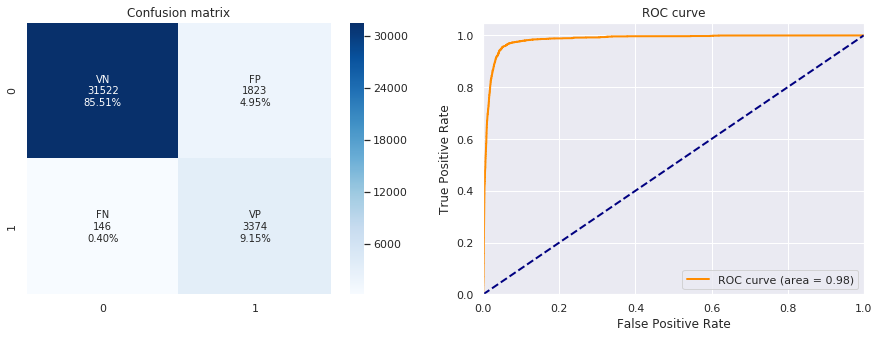

In [18]:
print('Logistic Regression')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     33345
           1       0.57      0.49      0.53      3520

    accuracy                           0.92     36865
   macro avg       0.76      0.73      0.74     36865
weighted avg       0.91      0.92      0.91     36865

AUC:  0.9309352124483703


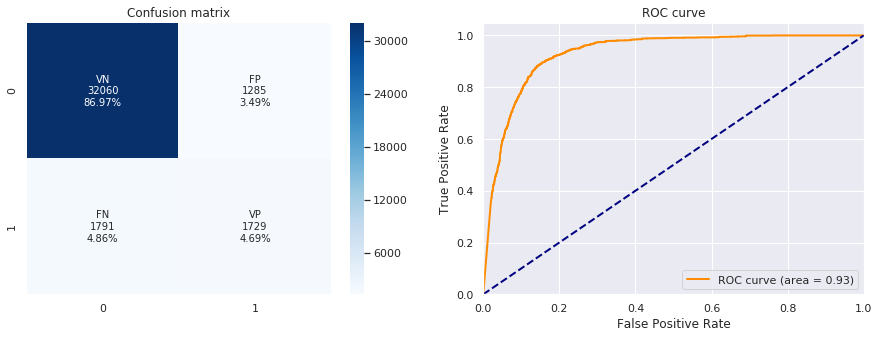

In [19]:
print('Bernoulli Naive-Bayes')
bnb = BernoulliNB().fit(X_train, y_train)
y_pred = bnb.predict(X_test)
y_prob = bnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('bernoulli naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multinomial Naive-Bayes
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     33345
           1       0.33      0.91      0.49      3520

    accuracy                           0.82     36865
   macro avg       0.66      0.86      0.69     36865
weighted avg       0.93      0.82      0.85     36865

AUC:  0.9428548814733025


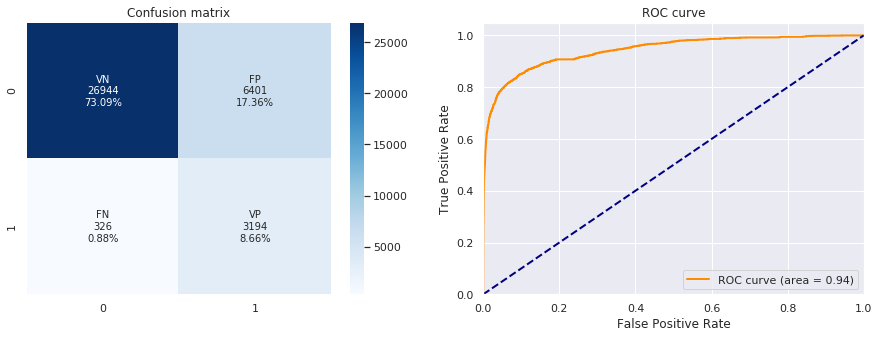

In [20]:
print('Multinomial Naive-Bayes')
mnb = MultinomialNB().fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_prob = mnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('multinomial naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Linear Support Vector Machine
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     33345
           1       0.74      0.97      0.84      3520

    accuracy                           0.96     36865
   macro avg       0.87      0.97      0.91     36865
weighted avg       0.97      0.96      0.97     36865



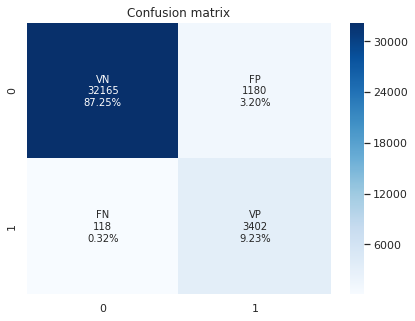

In [21]:
print('Linear Support Vector Machine')
svm = LinearSVC().fit(X_train, y_train)
y_pred = svm.predict(X_test)
#y_prob = svm.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred)

model.append('linear svm')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

In [22]:
print('KNN')
rf = KNeighborsClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('knn')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

KNN


KeyboardInterrupt: 

In [ ]:
print('Random Forest')
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('random forest')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

In [ ]:
print('Gradient Boosting')
gb = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('gradient boosting')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

In [ ]:
print('Multilayer perceptron')
mlp = MLPClassifier(max_iter=10,verbose=True).fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('mlp')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

## Results

In [ ]:
end_time = time.time()
ellapsed_time = end_time - start_time
print('ellapsed time (min):', ellapsed_time/60)

In [ ]:
df_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})

df_metrics['vocab'] = [vocab_size]*len(df_metrics)
df_metrics

In [ ]:
file = 'results/2018/ml/' + experiment + '.csv'
df_metrics.to_csv(file, index = False)
file

# Error examples with random forest

In [ ]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_pred = mlp.predict(X_test)
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('Total test data:', len(y_pred))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

In [ ]:
texts_FN = [texts_test[fn] for fn in FN]
texts_FP = [texts_test[fp] for fp in FP]

### False negative

In [ ]:
for fn in texts_FN:
    print('***')
    print(fn)
    print('***')

### False positives

In [ ]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()

# Hyperparameter tunning

In [ ]:
#validation set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify = y_train)